# OCR auf Bozner Zeitung: Trainieren des Algorithmus, Output (1842-1848)

Laden der zunächst erforderlichen Libraries:

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import skimage
import os

## 1. Der Trainingsdatensatz

Angabe des Pfades, der zu den Trainingsdaten führt. Bei mir wohnen die Trainingsdaten auf meiner lokalen Festplatte, im Unterordner **Training_Data_Reshape_200x200**.

In [2]:
data_path = '/Users/Michael/Anaconda3/Jupiter_Notebooks/DigitalScholarship-UB-Bern/Bozner_OCR/Training_Data_Reshape_200x200_Imp/'

Ich schaue mir an, wie die Trainingsdaten in Unterordnern organisiert sind. Hierzu verwende ich die Library **glob**. Nähres zu dieser Library findet man unter: https://docs.python.org/2/library/glob.html.

In [3]:
samples = np.sort(glob.glob(data_path+'*'))
print(samples)

['/Users/Michael/Anaconda3/Jupiter_Notebooks/DigitalScholarship-UB-Bern/Bozner_OCR/Training_Data_Reshape_200x200_Imp\\0'
 '/Users/Michael/Anaconda3/Jupiter_Notebooks/DigitalScholarship-UB-Bern/Bozner_OCR/Training_Data_Reshape_200x200_Imp\\1'
 '/Users/Michael/Anaconda3/Jupiter_Notebooks/DigitalScholarship-UB-Bern/Bozner_OCR/Training_Data_Reshape_200x200_Imp\\2'
 '/Users/Michael/Anaconda3/Jupiter_Notebooks/DigitalScholarship-UB-Bern/Bozner_OCR/Training_Data_Reshape_200x200_Imp\\3'
 '/Users/Michael/Anaconda3/Jupiter_Notebooks/DigitalScholarship-UB-Bern/Bozner_OCR/Training_Data_Reshape_200x200_Imp\\4'
 '/Users/Michael/Anaconda3/Jupiter_Notebooks/DigitalScholarship-UB-Bern/Bozner_OCR/Training_Data_Reshape_200x200_Imp\\5'
 '/Users/Michael/Anaconda3/Jupiter_Notebooks/DigitalScholarship-UB-Bern/Bozner_OCR/Training_Data_Reshape_200x200_Imp\\6'
 '/Users/Michael/Anaconda3/Jupiter_Notebooks/DigitalScholarship-UB-Bern/Bozner_OCR/Training_Data_Reshape_200x200_Imp\\7'
 '/Users/Michael/Anaconda3/Jupit

Wie man sieht, sind die Trainingsdaten in 10 Unterordnern gespeichert (0-9), auf die ich im nächsten Schritt zugreife.

In diesem Schritt werden die Trainingsdaten aus den Unterordern entnommen und in eine Liste eingefügt, die **all_data** heisst.
Mit der Zahl in **num_samples** lege ich fest, wie viele Bilder pro Unterorder entnommen werden sollen. 
  
Mit **num_samples = 113** entnehme ich aus jedem Unterordner 113 Bilder.  
Mit **replace=False** stelle ich sicher, dass dies stets verschiedene Bilder sind (d.h. nicht 2x das gleiche Bild).  
Mit **np.random.choice()** lege ich fest, dass die 113 Bilder jeweils zufällig ausgewählt werden sollen.  

In [4]:
num_samples = 113

all_data = []
for ind, s in enumerate(samples[0:10]):
    files = glob.glob(s+'/*.png')
    
    data = [skimage.transform.rescale(skimage.io.imread(files[x], as_gray=True), 1, anti_aliasing=False, multichannel=False, mode='reflect') 
                 for x in np.random.choice(np.arange(len(files)),num_samples,replace=False)]
    
    all_data.append(data)

Die Liste **all_data** enthält nun die aufgerufenen Daten (d.h. in diesem Fall: Pixelwerte, weil wir es mit Bildern zu tun haben) als Elemente, die mit Kommata getrennt sind.
Mit **np.concatenate()** und **np.reshape()** werden diese Daten in die für die Library **scikit-learn** erforderliche Form gebracht. Diese Library brauchen wir weiter unten fürs Machine Learning.

In [5]:
data = np.concatenate(all_data,axis = 0)

In [6]:
data.shape

(1130, 200, 200)

In [7]:
d2_data = np.reshape(data, (num_samples*10, 40000))

## 2. Erzeugen der Trainingskategorien

Den Trainingsdaten werden nun die erforderlichen Kategorien zugeordnet. Dabei werden beispielsweise alle zuvor in die Liste **all_data** eingespielten Daten aus dem **Unterordner 0** der Kategorie **0** zugordnet.

In [8]:
cats = [str(i) for i in range(len(all_data))]
category = np.concatenate([[cats[i] for j in range(num_samples)] for i in range(len(cats))])

Die Variable **Category** enthält diese Kategorieinformationen. Gibt man sie aus, sieht man sehr schön, dass jeder Kategorie von **0 bis 9** jeweils 113 Datenwerte zugeordnet sind. Das entspricht genau der in Zelle 4 mit **num_samples** definierten Datenmenge pro Kategorie.

In [9]:
category

array(['0', '0', '0', ..., '9', '9', '9'], dtype='<U1')

## 3. Trainieren des Machine Learning Algorithmus

Wir haben nun zwei Entitäten generiert:
- eine Liste mit Pixel-Werten (unsere Trainingsdaten)
- eine Liste mit zugehörigen Kategorien   

Diese beiden Entitäten verwenden wir, um einen ML-Algorithmus zu trainieren.

Hierzu laden wir zunächst die für das Trainineren der ML-Algorithmus erforderlichen Libraries.  
Für unsere Anwendung verwenden wir einen Random-Forest-Classifier als ML-Algorithmus.

Vgl. hierzu: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix

Wie wir das im Workshop mit Matthias Müller gelernt haben, splitten wir die Trainingsdaten in einen Trainingsset und einen Testset. Dies tun wir, um die Performanz unseres Klassifikators zu testen.

Da wir nichts Näheres spezifizieren, werden 3/4 unserer Daten als Trainingsdaten verwendet und 1/4 als Testdaten. Vgl. hierzu auch: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html.  
  

In [11]:
Xtrain, Xtest, ytrain, ytest = train_test_split(d2_data, category, random_state=0)

Nun trainieren wir den Klassifikator und erstellen ein Vorhersagemodell, mit dem wir bei neuen Bildern vorhersagen können, zu welcher Kategorie sie voraussichtlich gehören.  
  
Bei unserem Klassifikator können verschiedene Parameter eingestellt werden. In diesem Fall verwenden wir bei **n_estimators** den Wert 1000. Die Parameter, die man variieren kann, sind aber schier unbegrenzt: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html. 

In [12]:
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Wir wenden nun den trainierten Algorithmus auf unsere Testdaten an.

In [13]:
ypred = model.predict(Xtest)

In [14]:
ypred

array(['2', '8', '2', '9', '6', '3', '4', '6', '0', '8', '2', '4', '5',
       '6', '9', '4', '3', '8', '2', '8', '4', '6', '1', '7', '4', '0',
       '5', '7', '4', '5', '9', '6', '7', '3', '2', '8', '4', '3', '3',
       '3', '4', '9', '5', '6', '5', '3', '9', '7', '4', '2', '8', '2',
       '0', '6', '1', '9', '3', '6', '0', '0', '7', '1', '9', '7', '5',
       '0', '7', '2', '6', '4', '9', '7', '1', '9', '8', '7', '0', '1',
       '5', '8', '4', '1', '2', '9', '0', '3', '0', '6', '9', '5', '2',
       '1', '9', '4', '9', '2', '9', '5', '8', '5', '0', '0', '5', '1',
       '4', '7', '6', '9', '8', '6', '8', '0', '5', '5', '4', '6', '3',
       '9', '8', '8', '7', '8', '5', '1', '1', '2', '9', '3', '0', '4',
       '7', '4', '6', '0', '9', '6', '1', '5', '8', '9', '5', '7', '5',
       '4', '6', '8', '8', '2', '7', '0', '8', '2', '6', '3', '7', '9',
       '0', '9', '0', '8', '6', '5', '6', '7', '4', '4', '3', '7', '5',
       '3', '3', '5', '3', '0', '8', '7', '8', '7', '2', '9', '0

Wir können einen ersten Eindruck von der Vorhersagequalität unseres Algorithmus bekommen, indem wir anhand einiger Testdaten überprüfen, was der Algorithmus für Vorhersagen macht.

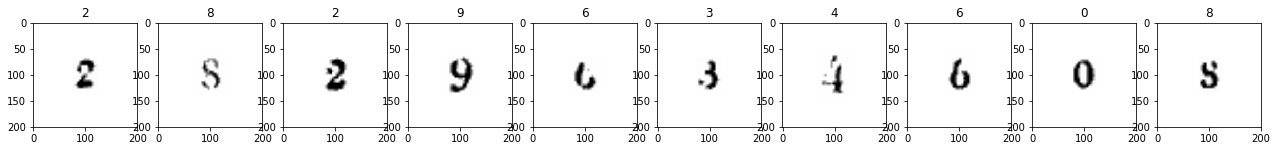

In [15]:
fig, ax = plt.subplots(1, 10, figsize = (22,10))
for x in range(10):
    ax[x].imshow(np.reshape(Xtest[x],(200,200)),cmap='gray')
    ax[x].set_title(ypred[x])
plt.show()

Das sieht gut aus. Wir können uns eine Statistik für die Vorhersagequalität bezüglich aller Testdaten ausgeben lassen:

In [16]:
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        24
           3       1.00      0.92      0.96        25
           4       1.00      1.00      1.00        28
           5       0.97      1.00      0.98        29
           6       1.00      1.00      1.00        34
           7       1.00      1.00      1.00        30
           8       0.97      1.00      0.99        34
           9       1.00      1.00      1.00        33

   micro avg       0.99      0.99      0.99       283
   macro avg       0.99      0.99      0.99       283
weighted avg       0.99      0.99      0.99       283



Aus der Statistik kann man einiges ablesen:
- die Grösse des Testdatensatzes beträgt 283 Bilder (1/4 von 113 Bilder x 10 Kategorien, d.h. 1/4 x 1130 = 282.5, aufgerundet 283)
- die Anzahl der für jede Kategorie getesteten Bilder ist unter **support** angegeben
- der f1-score gibt die Vorhersagegenauigkeit an. (Vgl. https://en.wikipedia.org/wiki/F1_score)  
  1.0 wäre demzufolge eine Vorhersagegenauigkeit von 100%.

## 4. Verwenden des trainierten Algorithmus auf neue Daten

Unser Algorithmus ist auf das Erkennen einstelliger Zahlen trainiert, weswegen wir ihm auch einstellige Zahlen geben müssen, um sinnvolle Vorhersagen zu bekommen.

Die Trainingsdaten sind aus Dokumenten der Jahre 1844 und 1845 generiert. Für die Vorhersage verwende ich Daten, die ich aus Dokumenten der Jahre 1842, 1843, 1846, 1847 und 1848 erzeugt habe.

Ich habe einen Ordner, der **Prediction_Data_Segm_1842** heisst. In diesem Ordner habe ich Bilder abgelegt, die genau wie die Trainingsbilder vorprozessiert wurden. Aus diesem Ordner entnehme ich irgendein Bild und spiele das ganze Vorhersageprozedere durch.

In [17]:
pred_image = skimage.io.imread('/Users/Michael/Anaconda3/Jupiter_Notebooks/DigitalScholarship-UB-Bern/Bozner_OCR/Prediction_Data_Segmented_1842-1848_200x200/Prediction_Data_Segm_1842/0.png', as_gray=True)

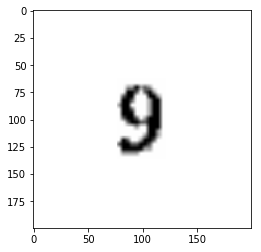

In [18]:
plt.imshow(pred_image, cmap = 'gray')
plt.show()

Wie bei den Trainingsdaten auch, muss ich dieses Bild in das für **scikit-learn** erforderliche Format bringen:

In [19]:
pred_image_new = np.reshape(pred_image, (1, 40000))

Jetzt kann ich die Vorhersage durchführen lassen:

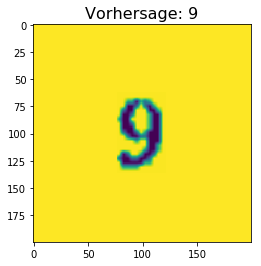

In [20]:
ypred = model.predict(pred_image_new)

plt.figure(figsize=(4,4))
plt.imshow(pred_image)
plt.title('Vorhersage: ' + ypred[0], fontsize=16)
plt.show()

## 5. Vorhersage für alle Bilder im Ordner für neu generierte Vorhersagebilder

Nachdem das für ein Bild klappt, möchte ich das für beliebig viele Bilder implementieren. Hierzu muss ich nur den Code, den ich habe, in ein Loop einbauen.

Zunächst definiere ich wieder den Pfad, wo Python meine Vorhersagedaten findet.

Dann baue ich ein Loop, bei dem ich Python sage, er soll sämtliche Files in meinem Input-Pfad der oben für ein Bild durchexerzierten Prozedur unterziehen.

### Hier die Vorhersage für Daten aus Dokumenten des Jahres 1842:

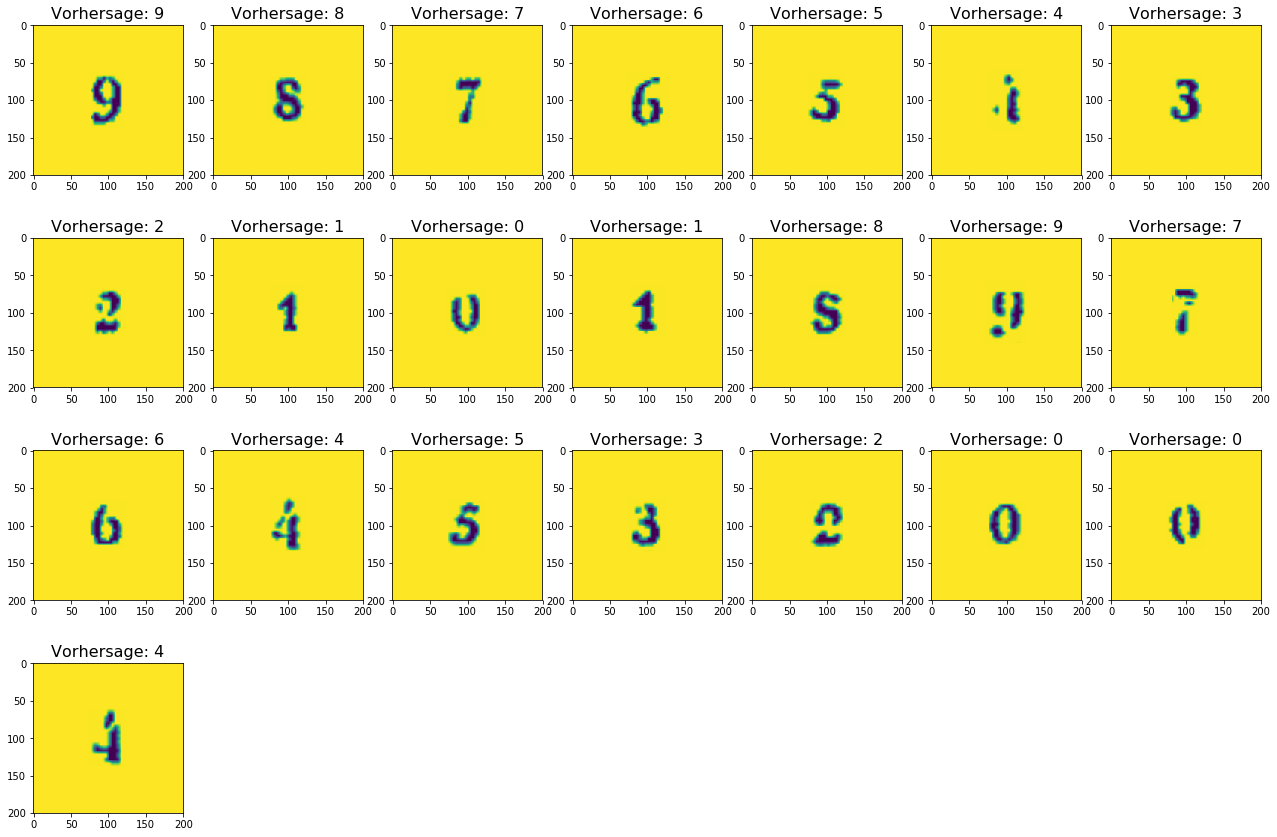

In [21]:
path_input_42 = '/Users/Michael/Anaconda3/Jupiter_Notebooks/DigitalScholarship-UB-Bern/Bozner_OCR/Prediction_Data_Segmented_1842-1848_200x200/Prediction_Data_Segm_1842/'

plt.figure(figsize=(22,15))
for i in range(0,22):
    bild = skimage.io.imread(path_input_42 + str(i) + '.png', as_gray=True)
    bild_new = np.reshape(bild, (1, 40000))
    ypred = model.predict(bild_new)
    
    plt.subplot(4,7,i+1)
    plt.imshow(bild)
    plt.title('Vorhersage: ' + ypred[0], fontsize=16)
    
plt.show()

### Hier die Vorhersage für Daten aus Dokumenten des Jahres 1843:

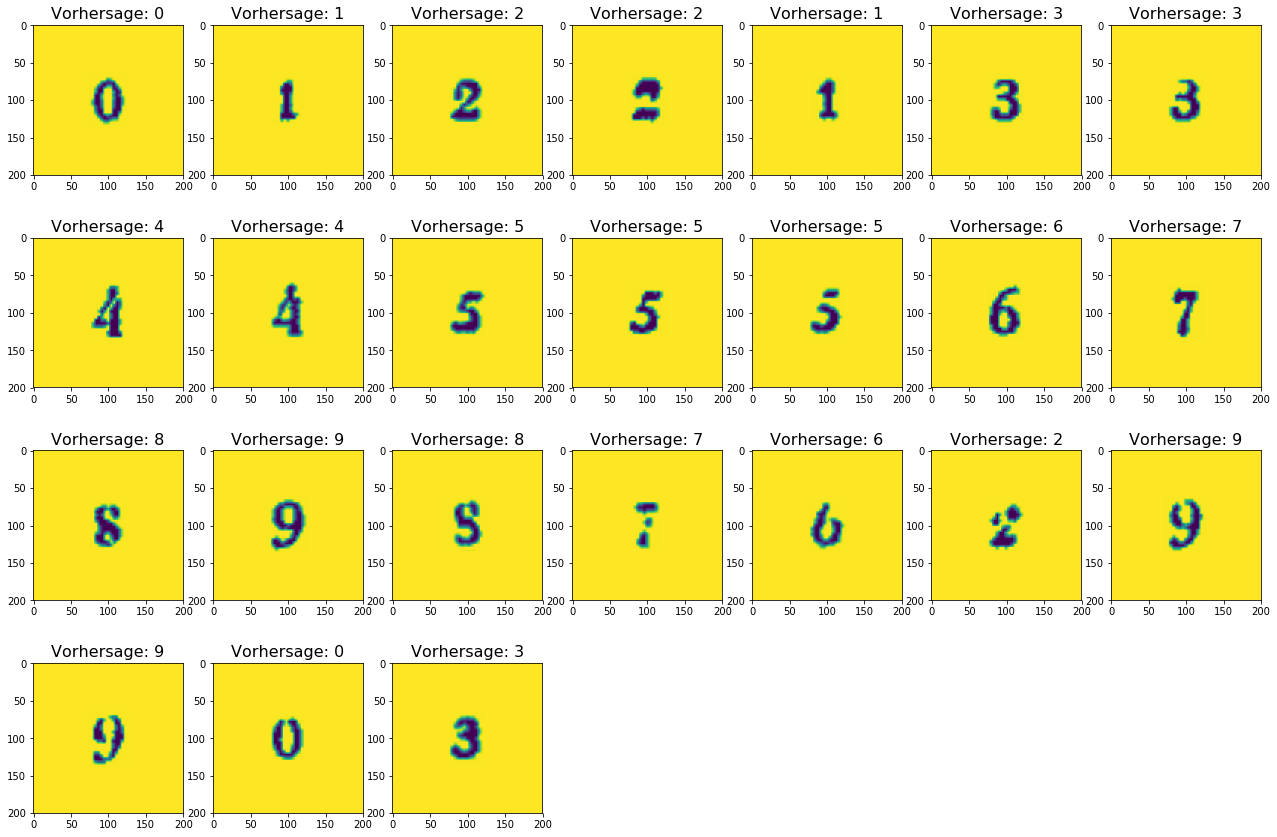

In [22]:
path_input_43 = '/Users/Michael/Anaconda3/Jupiter_Notebooks/DigitalScholarship-UB-Bern/Bozner_OCR/Prediction_Data_Segmented_1842-1848_200x200/Prediction_Data_Segm_1843/'

plt.figure(figsize=(22,15))
for i in range(0,24):
    bild = skimage.io.imread(path_input_43 + str(i) + '.png', as_gray=True)
    bild_new = np.reshape(bild, (1, 40000))
    ypred = model.predict(bild_new)
    
    plt.subplot(4,7,i+1)
    plt.imshow(bild)
    plt.title('Vorhersage: ' + ypred[0], fontsize=16)
    
plt.show()

### Hier die Vorhersage für Daten aus Dokumenten des Jahres 1846:

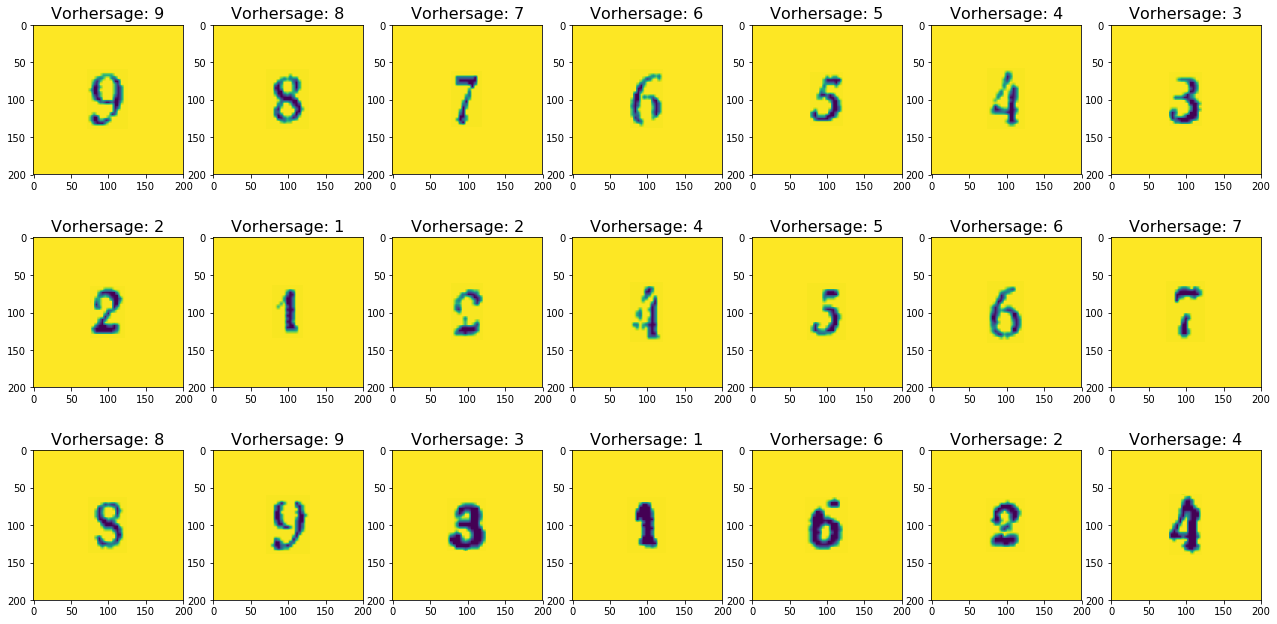

In [23]:
path_input_46 = '/Users/Michael/Anaconda3/Jupiter_Notebooks/DigitalScholarship-UB-Bern/Bozner_OCR/Prediction_Data_Segmented_1842-1848_200x200/Prediction_Data_Segm_1846/'

plt.figure(figsize=(22,15))
for i in range(0,21):
    bild = skimage.io.imread(path_input_46 + str(i) + '.png', as_gray=True)
    bild_new = np.reshape(bild, (1, 40000))
    ypred = model.predict(bild_new)
    
    plt.subplot(4,7,i+1)
    plt.imshow(bild)
    plt.title('Vorhersage: ' + ypred[0], fontsize=16)
    
plt.show()

### Hier die Vorhersage für Daten aus Dokumenten des Jahres 1847:

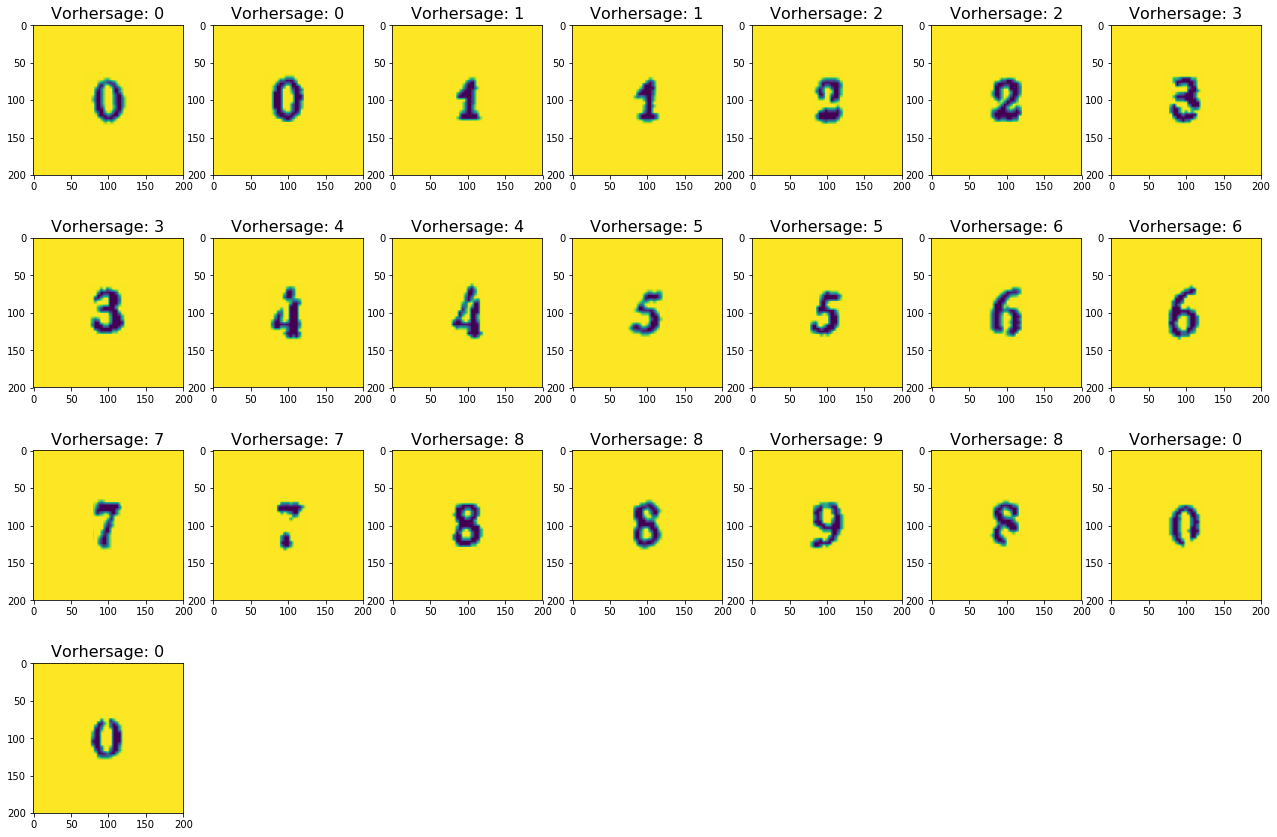

In [24]:
path_input_47 = '/Users/Michael/Anaconda3/Jupiter_Notebooks/DigitalScholarship-UB-Bern/Bozner_OCR/Prediction_Data_Segmented_1842-1848_200x200/Prediction_Data_Segm_1847/'

plt.figure(figsize=(22,15))
for i in range(0,22):
    bild = skimage.io.imread(path_input_47 + str(i) + '.png', as_gray=True)
    bild_new = np.reshape(bild, (1, 40000))
    ypred = model.predict(bild_new)
    
    plt.subplot(4,7,i+1)
    plt.imshow(bild)
    plt.title('Vorhersage: ' + ypred[0], fontsize=16)
    
plt.show()

### Hier die Vorhersage für Daten aus Dokumenten des Jahres 1848:

Hier gibt es den Sonderfall, dass wir auch sehr schlecht digitalisierte Dokumente haben (z.B. 12-15-1848 oder 12-22-1848).
Es ist spannend zu sehen, wie weit ein mit genügend Daten trainierter Algorithmus hier gute Vorhersagen machen kann.

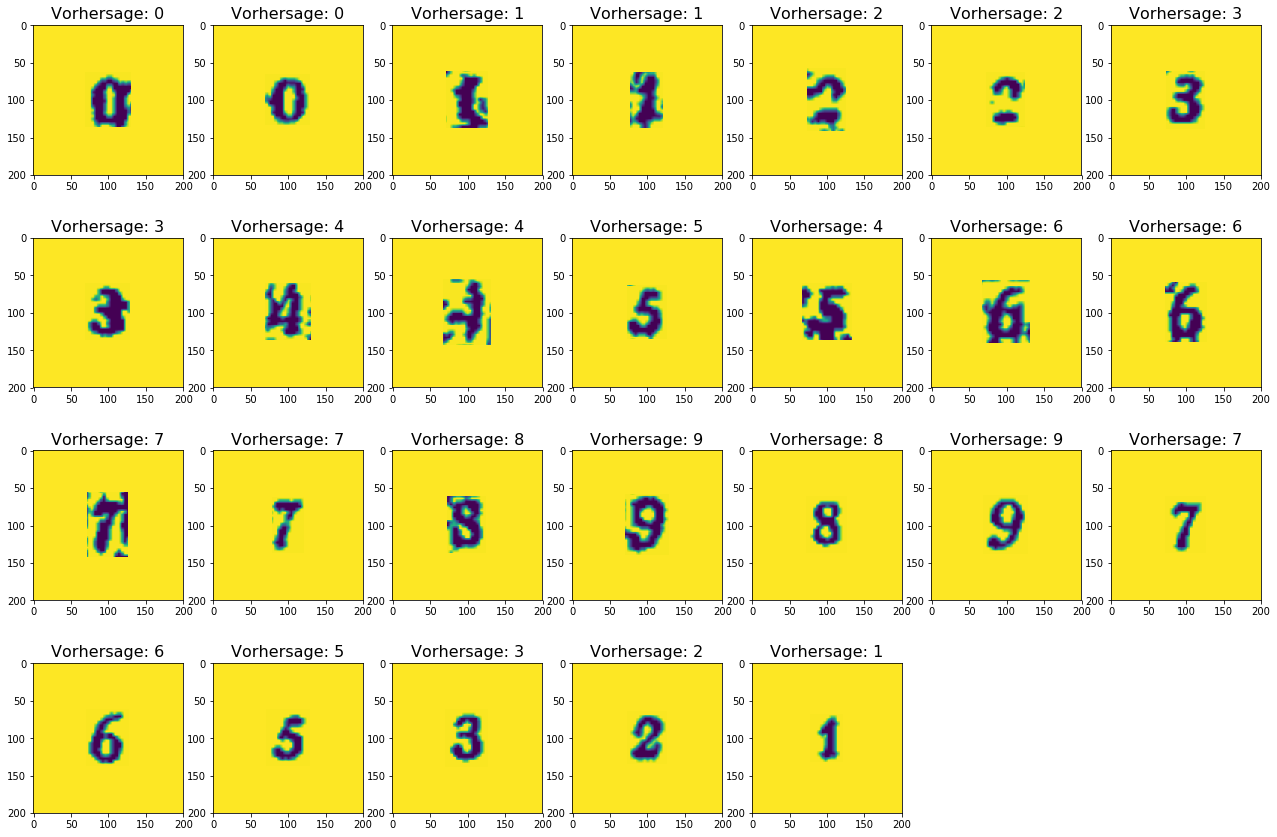

In [25]:
path_input_48 = '/Users/Michael/Anaconda3/Jupiter_Notebooks/DigitalScholarship-UB-Bern/Bozner_OCR/Prediction_Data_Segmented_1842-1848_200x200/Prediction_Data_Segm_1848/'

plt.figure(figsize=(22,15))
for i in range(0,26):
    bild = skimage.io.imread(path_input_48 + str(i) + '.png', as_gray=True)
    bild_new = np.reshape(bild, (1, 40000))
    ypred = model.predict(bild_new)
    
    plt.subplot(4,7,i+1)
    plt.imshow(bild)
    plt.title('Vorhersage: ' + ypred[0], fontsize=16)
    
plt.show()

Erstaunlicherweise bekommt man selbst bei den schlecht digitalisierten Bildern sehr gute Vorhersagen !
Insgesamt haben wir hier für die betrachteten Daten eine Vorhersagequalität von 100% !!

Um das Spiel auf die Spitze zu treiben, habe ich auch besonders schlecht digitalisierte Daten aus dem Jahr 1848 getestet. Hier das Resultat:

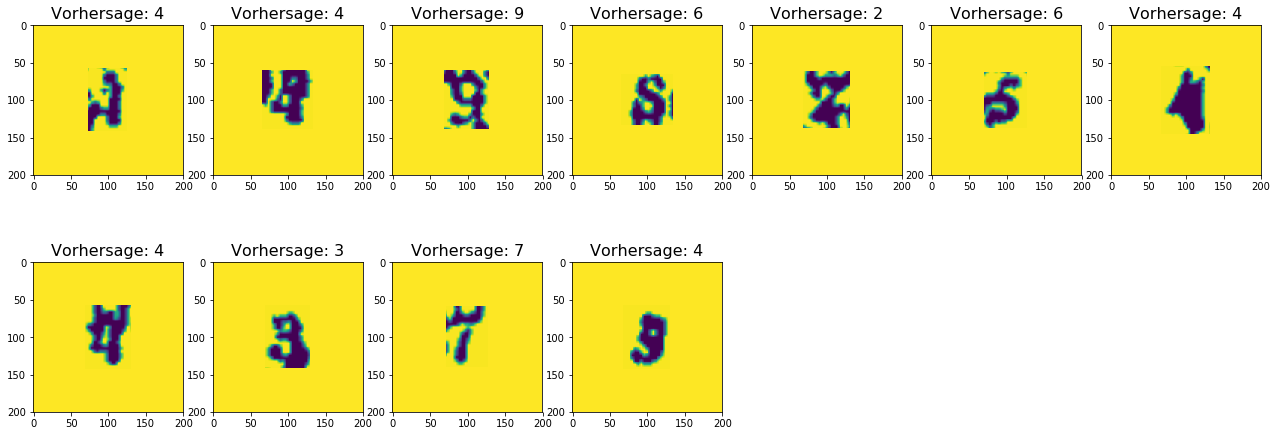

In [26]:
path_input_48_special = '/Users/Michael/Anaconda3/Jupiter_Notebooks/DigitalScholarship-UB-Bern/Bozner_OCR/Prediction_Data_Segmented_1842-1848_200x200/Prediction_Data_Segm_1848_Special/'

plt.figure(figsize=(22,8))
for i in range(26,37):
    bild = skimage.io.imread(path_input_48_special + str(i) + '.png', as_gray=True)
    bild_new = np.reshape(bild, (1, 40000))
    ypred = model.predict(bild_new)
    
    plt.subplot(2,7,i-25)
    plt.imshow(bild)
    plt.title('Vorhersage: ' + ypred[0], fontsize=16)
    
plt.show()

Der Algorithmus versagt bei 4 von 11 fällen, liefert aber angesichts der Datenqualität eine wie ich finde erstaunlich gute Prognose.

## Besonderheit

Sind die Vorhersagebilder nicht auf die gleiche Weise generiert wie die Trainingsbilder, ist die Vorhersage wesentlich schlechter. Im folgenden Beispiel sind die Ziffern in den Vorhersagebildern grösser als in den zuvor gezeigten Beispielen.

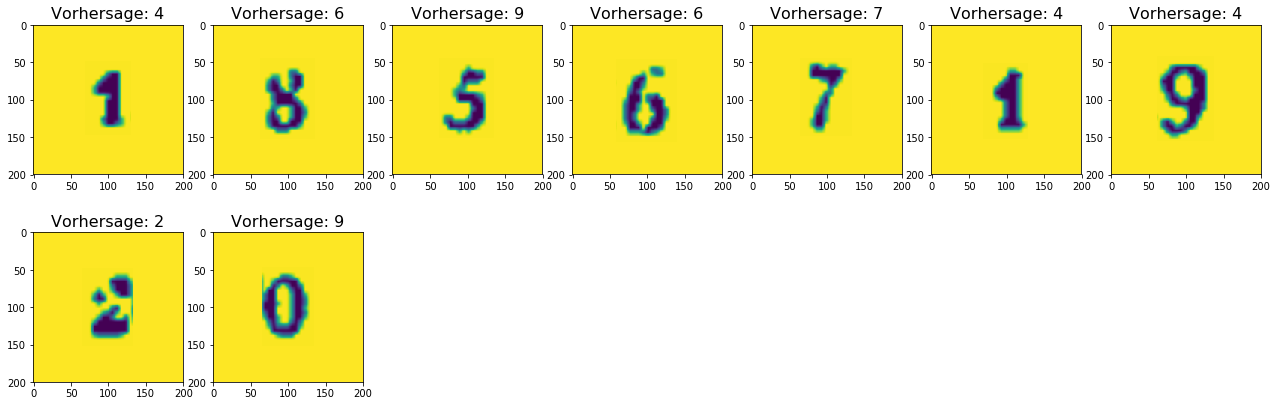

In [27]:
path_input = '/Users/Michael/Anaconda3/Jupiter_Notebooks/DigitalScholarship-UB-Bern/Bozner_OCR/Prediction_Data_Segmented_Reshaped/'

plt.figure(figsize=(22,7))
for i in range(0,9):
    bild = skimage.io.imread(path_input + str(i) + '.png', as_gray=True)
    bild_new = np.reshape(bild, (1, 40000))
    ypred = model.predict(bild_new)
    
    plt.subplot(2,7,i+1)
    plt.imshow(bild)
    plt.title('Vorhersage: ' + ypred[0], fontsize=16)
    
plt.show() 

Man sieht, die Vorhersage ist viel schlechter.

Zum Vergleich:

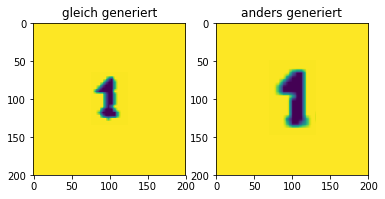

In [78]:
path_input_42 = '/Users/Michael/Anaconda3/Jupiter_Notebooks/DigitalScholarship-UB-Bern/Bozner_OCR/Prediction_Data_Segmented_1842-1848_200x200/Prediction_Data_Segm_1842/'
path_input = '/Users/Michael/Anaconda3/Jupiter_Notebooks/DigitalScholarship-UB-Bern/Bozner_OCR/Prediction_Data_Segmented_Reshaped/'

plt.figure(figsize=(6,8))
bild_korrekt = skimage.io.imread(path_input_42 + str(10) + '.png', as_gray=True)
bild_falsch = skimage.io.imread(path_input + str(0) + '.png', as_gray=True)

plt.subplot(1,2,1)
plt.imshow(bild_korrekt)
plt.title('gleich generiert', fontsize=12)

plt.subplot(1,2,2)
plt.imshow(bild_falsch)
plt.title('anders generiert', fontsize=12)

plt.show()

## 6. Systematischer Vergleich mit Tesseract

Es wäre nun interessant, den mit unseren Daten trainierten Klassifier mal mit Tesseract zu vergleichen, um zu sehen, welches Vorhersagetool besser abschneidet.

Hierzu lade ich Tesseract und führe zunächst eine Vorhersage für eine Zahl aus meinem Vorhersagedatensatz durch:

In [31]:
import pytesseract
from pytesseract import image_to_string

pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

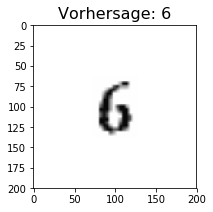

In [32]:
path_input_42 = '/Users/Michael/Anaconda3/Jupiter_Notebooks/DigitalScholarship-UB-Bern/Bozner_OCR/Prediction_Data_Segmented_1842-1848_200x200/Prediction_Data_Segm_1842/'

testzahl = skimage.io.imread(path_input_42 + '3.png')
zahl = pytesseract.image_to_string(testzahl, lang='deu_frak',config='--psm 13 --oem 3 -c tessedit_char_whitelist=0123456789')

plt.figure(figsize=(3,3))
plt.imshow(testzahl)
plt.title('Vorhersage: ' + zahl, fontsize=16)
plt.show()

Das sieht sehr gut aus. Mal sehen wie Tesseract abschneidet, wenn er die gleichen Bilder zu beurteilen bekommt, wie unser Klassifier.

### Tesseracts Vorhersage für Daten aus Dokumenten des Jahres 1842:

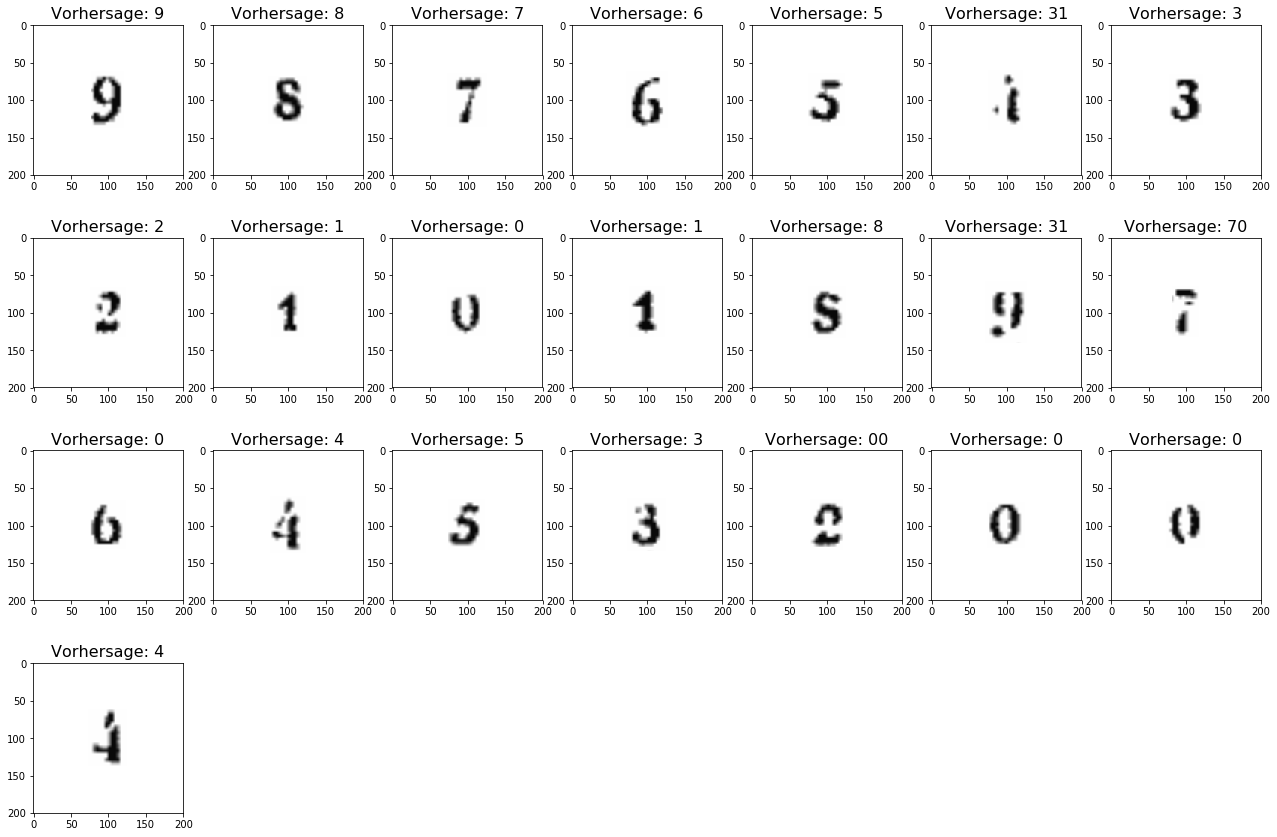

In [33]:
plt.figure(figsize=(22,15))
for i in range(0,22):
    bild = skimage.io.imread(path_input_42 + str(i) + '.png')
    zahl = pytesseract.image_to_string(bild, lang='deu_frak',config='--psm 13 --oem 3 -c tessedit_char_whitelist=0123456789')
    
    plt.subplot(4,7,i+1)
    plt.imshow(bild)
    plt.title('Vorhersage: ' + zahl, fontsize=16)  
plt.show()

Vorhersagequalität: 5 falsch, 17 richtig, d.h. Genauigkeit von 77.3 %. 

### Tesseracts Vorhersage für Daten aus Dokumenten des Jahres 1843:

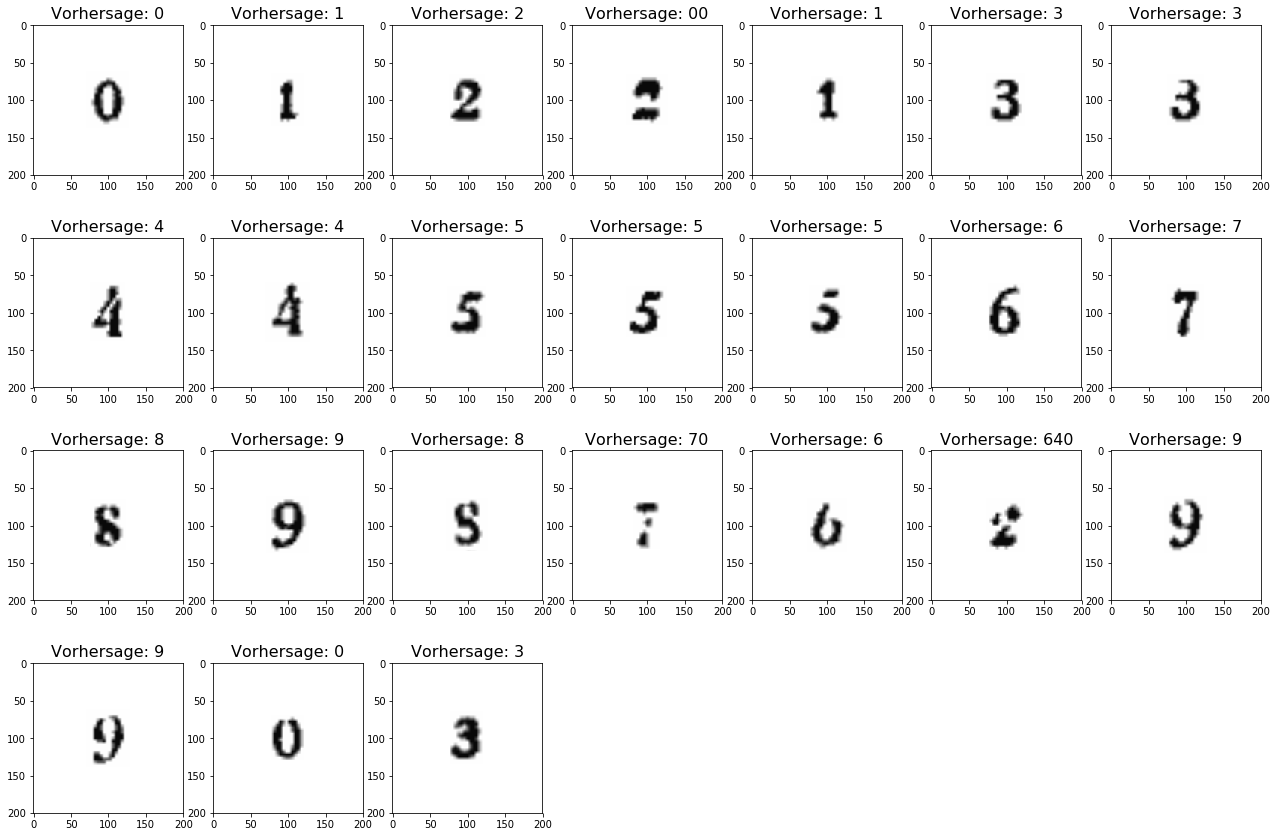

In [38]:
path_input_43 = '/Users/Michael/Anaconda3/Jupiter_Notebooks/DigitalScholarship-UB-Bern/Bozner_OCR/Prediction_Data_Segmented_1842-1848_200x200/Prediction_Data_Segm_1843/'

plt.figure(figsize=(22,15))
for i in range(0,24):
    bild = skimage.io.imread(path_input_43 + str(i) + '.png')
    zahl = pytesseract.image_to_string(bild, lang='deu_frak',config='--psm 13 --oem 3 -c tessedit_char_whitelist=0123456789')
    
    plt.subplot(4,7,i+1)
    plt.imshow(bild)
    plt.title('Vorhersage: ' + zahl, fontsize=16)
plt.show()

Vorhersagequalität: 3 falsch, 21 richtig, d.h. Genauigkeit von 87.5 %. 

### Tesseracts Vorhersage für Daten aus Dokumenten des Jahres 1846:

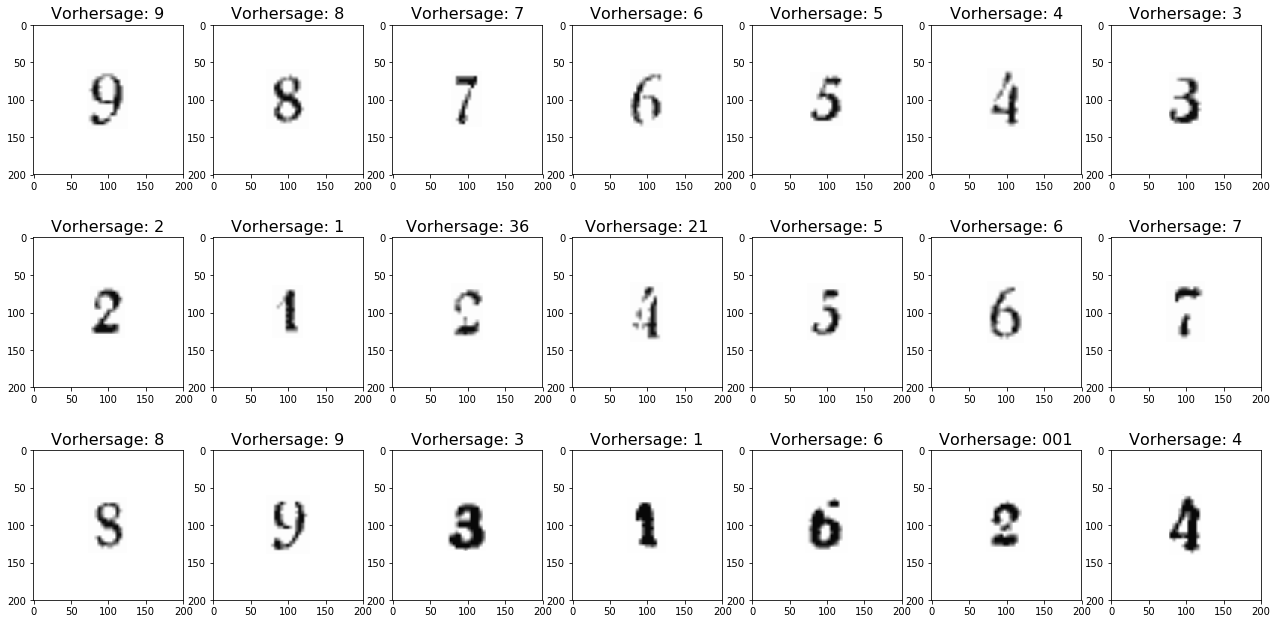

In [37]:
path_input_46 = '/Users/Michael/Anaconda3/Jupiter_Notebooks/DigitalScholarship-UB-Bern/Bozner_OCR/Prediction_Data_Segmented_1842-1848_200x200/Prediction_Data_Segm_1846/'

plt.figure(figsize=(22,15))
for i in range(0,21):
    bild = skimage.io.imread(path_input_46 + str(i) + '.png')
    zahl = pytesseract.image_to_string(bild, lang='deu_frak',config='--psm 13 --oem 3 -c tessedit_char_whitelist=0123456789')
    
    plt.subplot(4,7,i+1)
    plt.imshow(bild)
    plt.title('Vorhersage: ' + zahl, fontsize=16)   
plt.show()

Vorhersagequalität: 3 falsch, 18 richtig, d.h. Genauigkeit von 85.7 %. 

### Tesseracts Vorhersage für Daten aus Dokumenten des Jahres 1847:

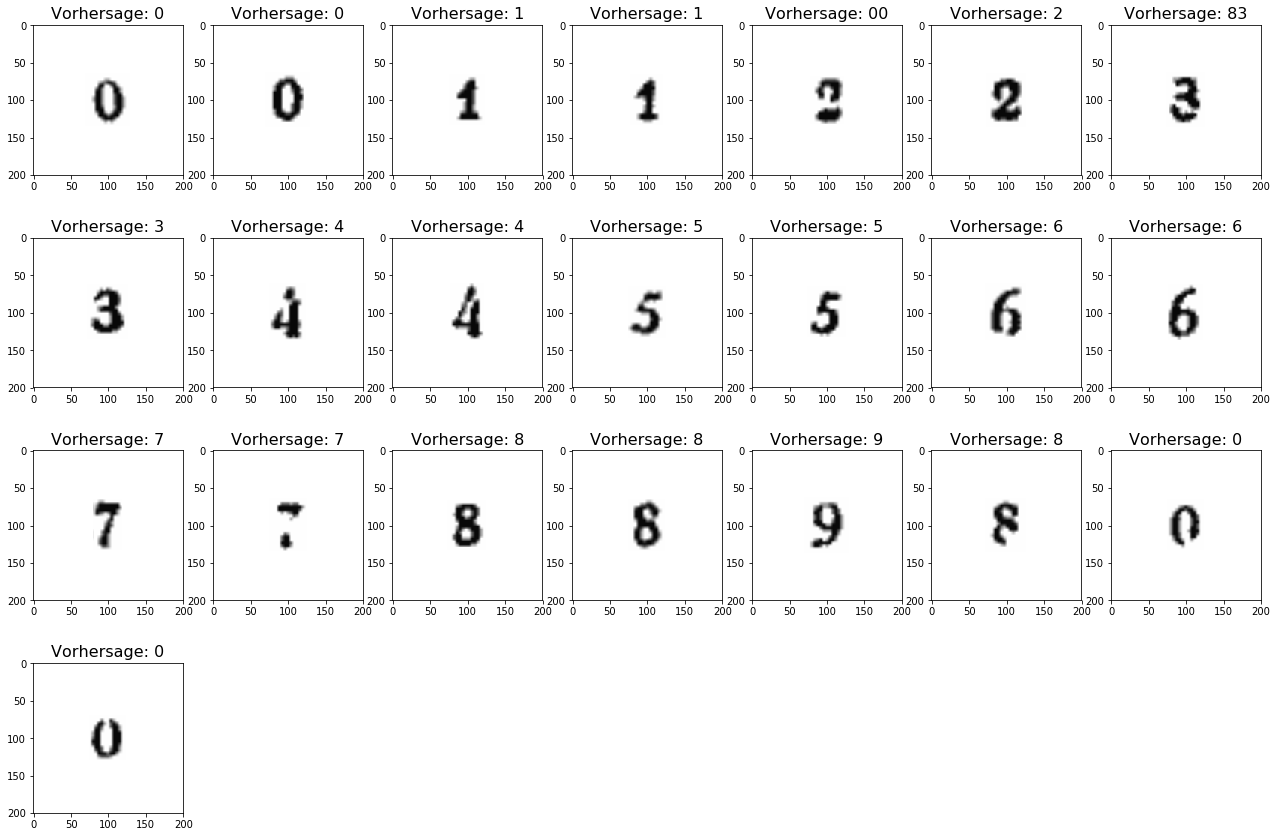

In [40]:
path_input_47 = '/Users/Michael/Anaconda3/Jupiter_Notebooks/DigitalScholarship-UB-Bern/Bozner_OCR/Prediction_Data_Segmented_1842-1848_200x200/Prediction_Data_Segm_1847/'

plt.figure(figsize=(22,15))
for i in range(0,22):
    bild = skimage.io.imread(path_input_47 + str(i) + '.png')
    zahl = pytesseract.image_to_string(bild, lang='deu_frak',config='--psm 13 --oem 3 -c tessedit_char_whitelist=0123456789')
    
    plt.subplot(4,7,i+1)
    plt.imshow(bild)
    plt.title('Vorhersage: ' + zahl, fontsize=16)
    
plt.show()

Vorhersagequalität: 2 falsch, 20 richtig, d.h. Genauigkeit von 90.9 %. 

### Tesseracts Vorhersage für Daten aus Dokumenten des Jahres 1848:

Hier ist zu beachten, dass Tesseract auch auf Bildern mit schlechter Qualität vorhersagen machen muss. 

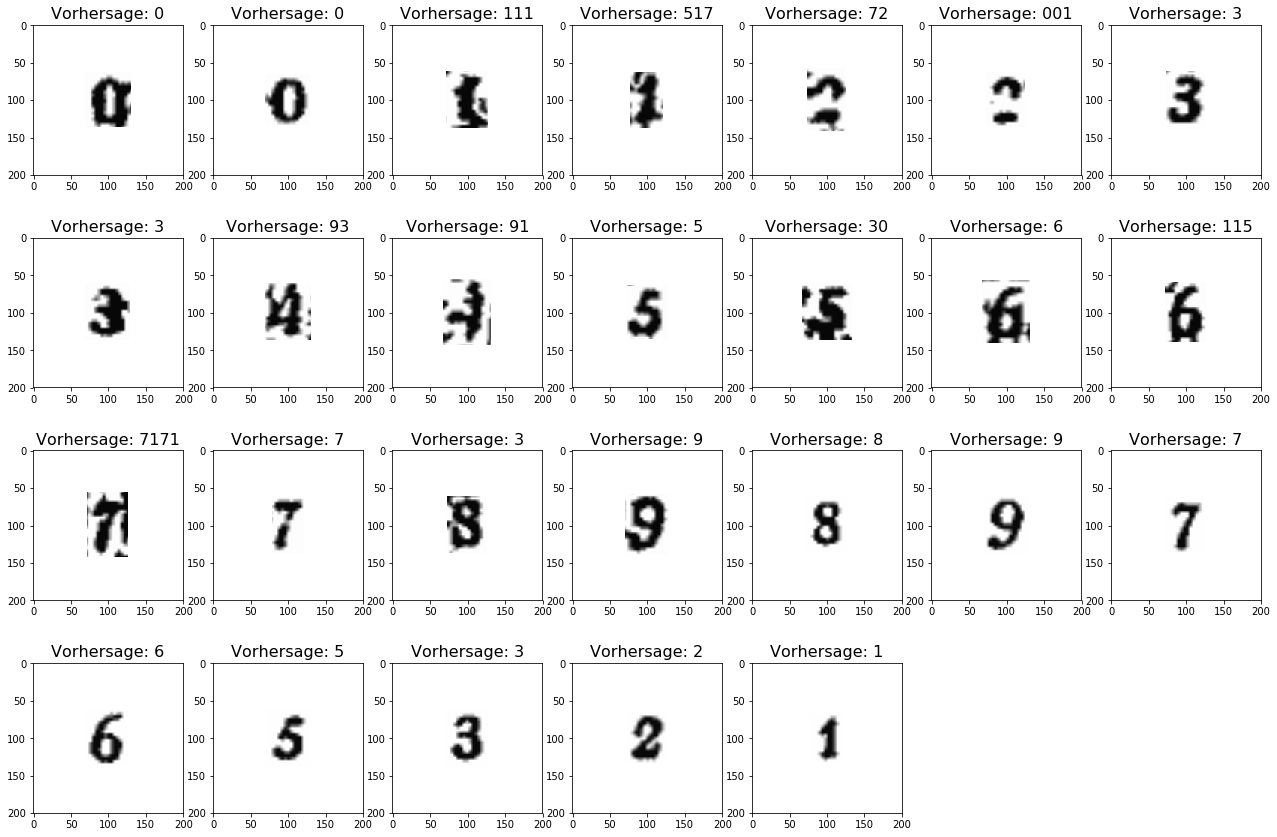

In [44]:
path_input_48 = '/Users/Michael/Anaconda3/Jupiter_Notebooks/DigitalScholarship-UB-Bern/Bozner_OCR/Prediction_Data_Segmented_1842-1848_200x200/Prediction_Data_Segm_1848/'

plt.figure(figsize=(22,15))
for i in range(0,26):
    bild = skimage.io.imread(path_input_48 + str(i) + '.png')
    zahl = pytesseract.image_to_string(bild, lang='deu_frak',config='--psm 13 --oem 3 -c tessedit_char_whitelist=0123456789')
    
    plt.subplot(4,7,i+1)
    plt.imshow(bild)
    plt.title('Vorhersage: ' + zahl, fontsize=16)
plt.show()

Vorhersagequalität: 10 falsch, 16 richtig, d.h. Genauigkeit von 61.5 %.  
Man sieht, dass Tesseract bei Bildern schlechter Qualität Schwierigkeiten hat, was aber für ein solches Allroundtool klar ist.

Ganz deutlich wird das für die besonders schlechten Bildern:

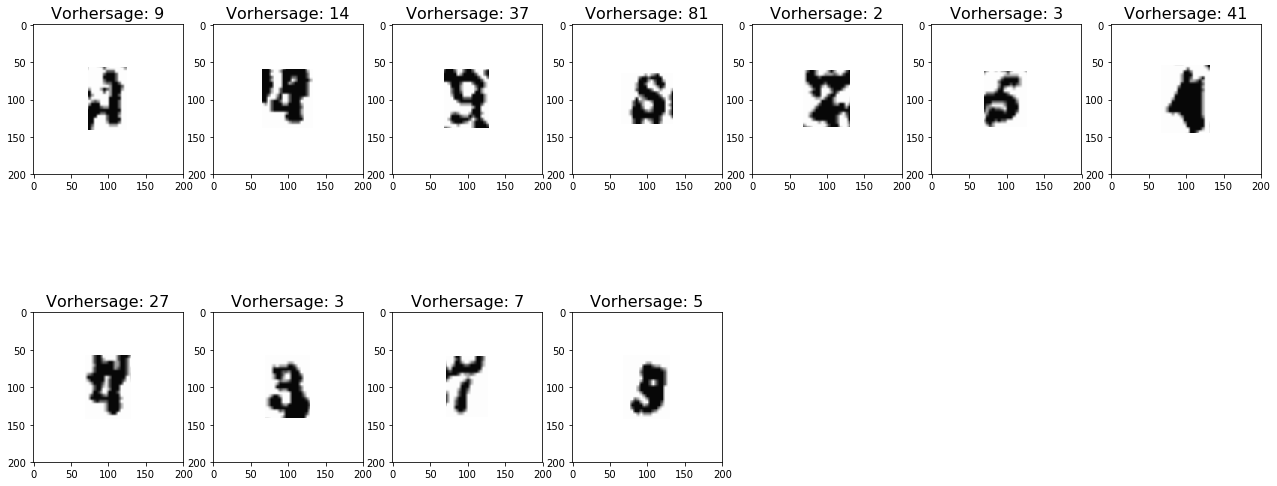

In [46]:
path_input_48_special = '/Users/Michael/Anaconda3/Jupiter_Notebooks/DigitalScholarship-UB-Bern/Bozner_OCR/Prediction_Data_Segmented_1842-1848_200x200/Prediction_Data_Segm_1848_Special/'

plt.figure(figsize=(22,15))
for i in range(26,37):
    bild = skimage.io.imread(path_input_48_special + str(i) + '.png')
    zahl = pytesseract.image_to_string(bild, lang='deu_frak',config='--psm 13 --oem 3 -c tessedit_char_whitelist=0123456789')
    
    plt.subplot(3,7,i-25)
    plt.imshow(bild)
    plt.title('Vorhersage: ' + zahl, fontsize=16)
plt.show()

Hier erkennt Tesseract nur 4 von 11 Bildern richtig.

## Zwischenfazit Klassifier - Tesserakt

Für die Daten aus den Jahren 1843, 1843, 1846, und 1847, d.h. wo nur Bilder hoher Qualität vorkommen, sieht die Vorhersagequalität folgendermassen aus:

**Selbsttrainierter Klassifier: 100 %** (89 von 89 richtig vorhergesagt)  
  
**Tesseract: 85.4 %** (76 von 89 richtig vorhergesagt)

## Besonderheit Tesseract

Obwohl Tesseract bei den hier gezeigten Daten etwas schlechter abschneidet als unser selbsttrainierter Klassifier, ist Tesseract besser geeignet, Skalierungsvarianzen zu tolerieren.

Während unser selbsttrainierter Klassifier bei anders generierten Vorhersagedaten Probleme hat:


--- Selbsttrainierter Klassifier ---



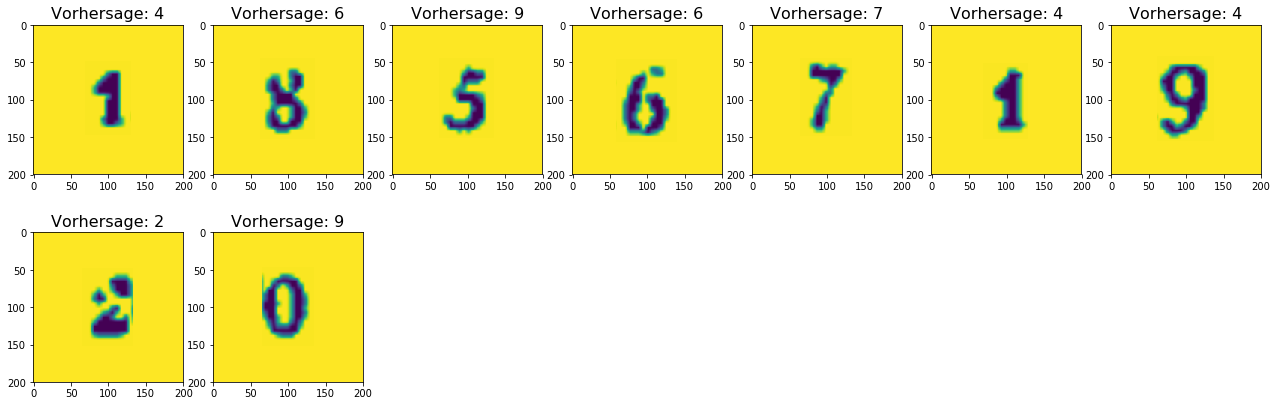

In [63]:
path_input_anders = '/Users/Michael/Anaconda3/Jupiter_Notebooks/DigitalScholarship-UB-Bern/Bozner_OCR/Prediction_Data_Segmented_Reshaped/'

print('')
print('\033[1m' + '--- Selbsttrainierter Klassifier ---')
print('')

plt.figure(figsize=(22,7))
for i in range(0,9):
    bild = skimage.io.imread(path_input_anders + str(i) + '.png', as_gray=True)
    bild_new = np.reshape(bild, (1, 40000))
    ypred = model.predict(bild_new)
    
    plt.subplot(2,7,i+1)
    plt.imshow(bild)
    plt.title('Vorhersage: ' + ypred[0], fontsize=16)
plt.show() 

kann Tesseract hier hervorragende Prognosen erstellen:


--- Tesseract ---



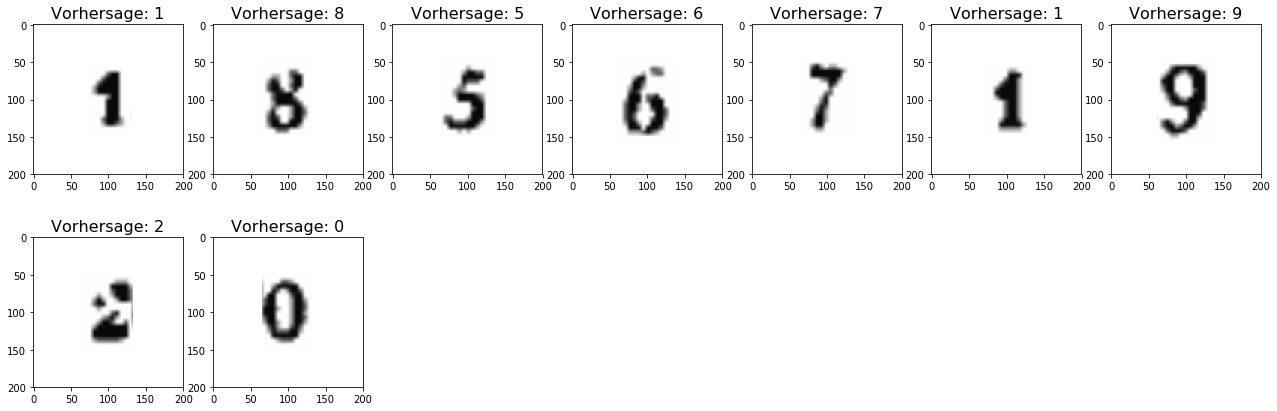

In [64]:
path_input_andersgeneriert = '/Users/Michael/Anaconda3/Jupiter_Notebooks/DigitalScholarship-UB-Bern/Bozner_OCR/Prediction_Data_Segmented_Reshaped/'

print('')
print('\033[1m' + '--- Tesseract ---')
print('')

plt.figure(figsize=(22,15))
for i in range(0,9):
    bild = skimage.io.imread(path_input_andersgeneriert + str(i) + '.png')
    zahl = pytesseract.image_to_string(bild, lang='deu_frak',config='--psm 13 --oem 3 -c tessedit_char_whitelist=0123456789')
    
    plt.subplot(4,7,i+1)
    plt.imshow(bild)
    plt.title('Vorhersage: ' + zahl, fontsize=16)   
plt.show()